# Self-Driving Car Nanodegree

## Project: Advanced Lane Finidng

## Imports

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import copy
from matplotlib.widgets import Slider
%matplotlib inline

## Camera Calibration

### Get image points from chessboard

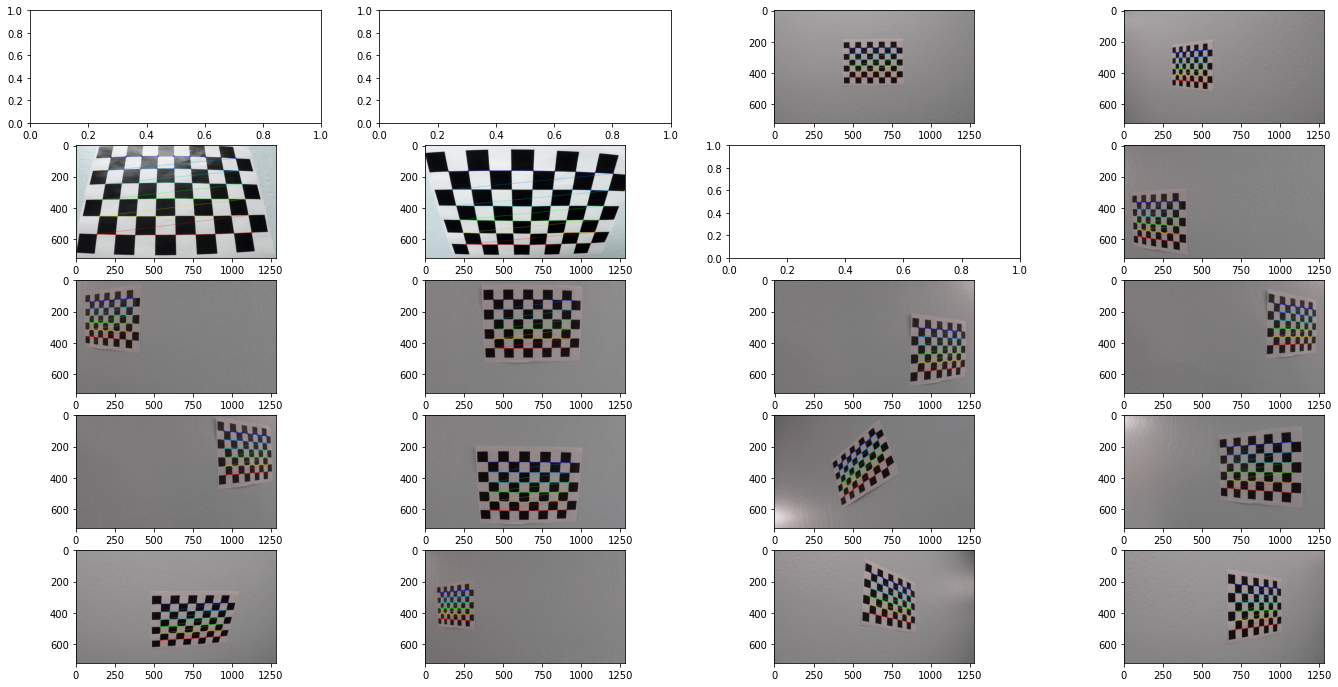

In [2]:
# dims of the chess board
nx = 9
ny = 6

# prepare the object point array [(0,0,0), (1,0,0) ... (9,6,0)]
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# used to diplay the result on one plot
f, axarr = plt.subplots(5,4,figsize=(24, 12))
counter = 0

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners (used for testing)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axarr[counter//4,counter%4].imshow(img)

    counter += 1

# cv2.destroyAllWindows()

### Get camera matrix and distortion coefficients

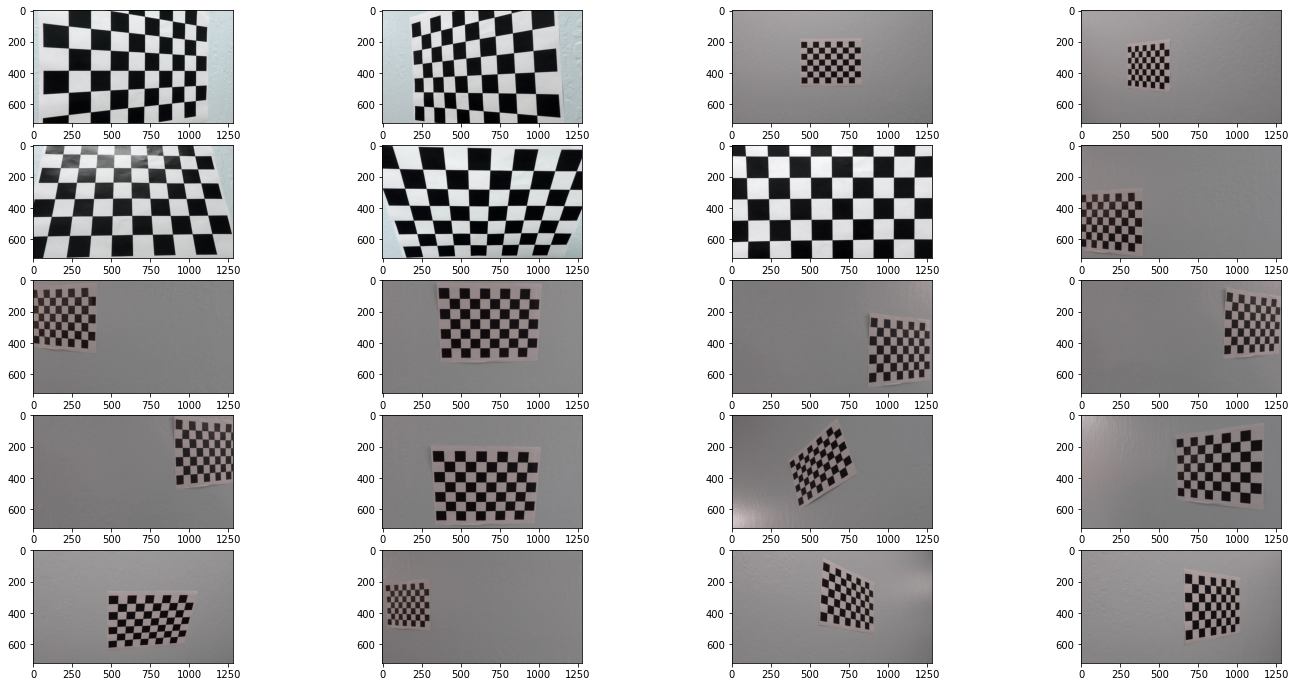

<Figure size 432x288 with 0 Axes>

In [3]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# used to diplay the result on one plot
f, axarr = plt.subplots(5,4,figsize=(24, 12))
counter = 0

# used for testing only
# show all undistorted chessboards
plt.figure()
for fname in images:
    img = cv2.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    axarr[counter//4,counter%4].imshow(undistorted)
    counter += 1

## Creating Thresholded Binary Image

### Sobel Operator

In [83]:
images = glob.glob('test_images/test*.jpg')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        return img

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

### Magnitude Sobel

In [82]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

### Direction Sobel

In [81]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_direction)
    binary_output[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

### HLS Color Threshold

In [80]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # 2) Apply a threshold to the S channel
    s_channel = hls_image[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    # 3) Return a binary image of threshold result
    return binary_output

### Combining Gradient and Color

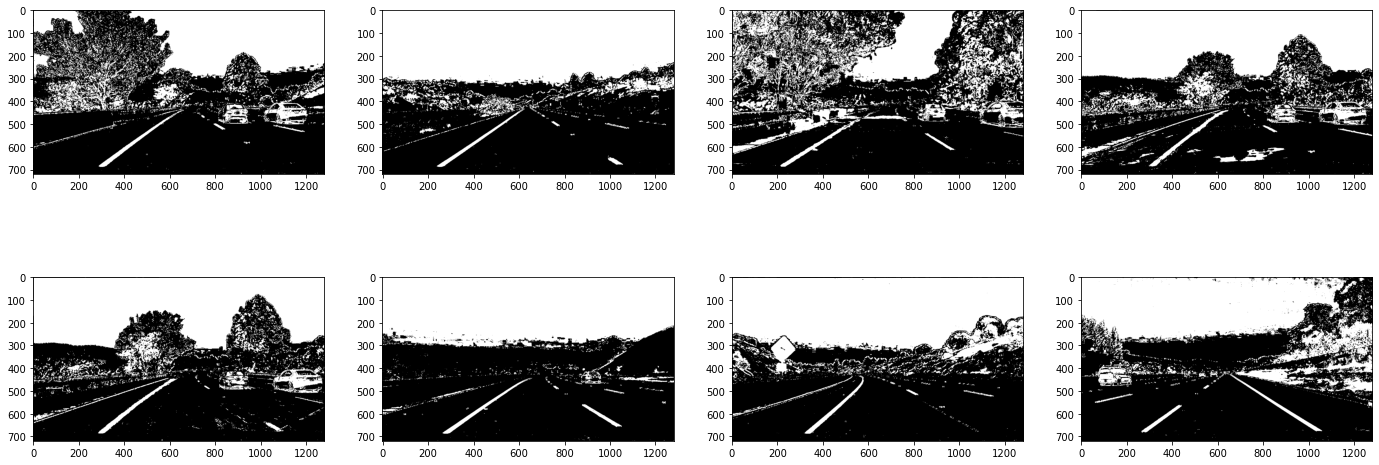

In [79]:
images = glob.glob('test_images/test*.jpg')

# Edit this function to create your own pipeline.
def threshold_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), ksize=3):
    image = np.copy(img)
    ksize = 7

    hls_binary = hls_select(image, thresh=(90, 255))

    gradx = abs_sobel_thresh(image, thresh=(25,255), sobel_kernel=ksize, orient='x')
    grady = abs_sobel_thresh(image, thresh=(25,255), sobel_kernel=ksize, orient='y')

    mag_binary = mag_thresh(image, thresh=(40,100), sobel_kernel=ksize)
    dir_binary = dir_threshold(image, thresh=(0.7, 1.3), sobel_kernel=ksize)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

    return combined

# used to diplay the result on one plot
f, axarr = plt.subplots(2,4,figsize=(24, 9))
counter = 0

for fname in images:
    image = cv2.imread(fname)
    result = threshold_pipeline(image)
    axarr[counter//4,counter%4].imshow(result, cmap='gray')
    counter += 1